## Spectral Clustering and Semi-Supervised Learning

#### This notebook contains different values and imports that can be used in this practical session.
#### Please keep the same variable names when provided in your report to make the work of teaching assistants easier. 
#### You can still change the values given or the sizes of the datasets treated if you believe it is usefull to illustrate your point.

#### You can directly edit the markdown boxes to add your comments and answers to the questions

In [ ]:
# Question 1 (imports and advised values):
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

n_samples = 200 # You can change these values
noise_level_list = [.05,.1,.2] # You can change these values

### Question 1 : Complete the code in the box below

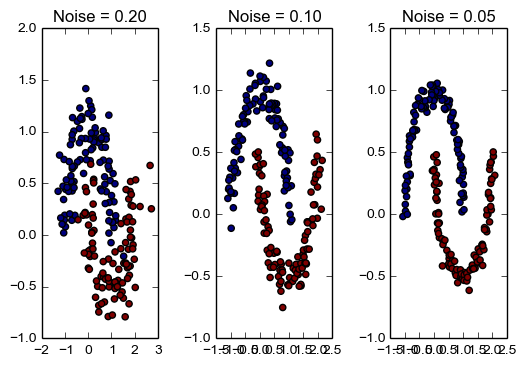

In [69]:
#A dictionnary which maps the noise level to the correponding moon dataset (if it has already been generated)
noisy_moons = {} 
for i in range(len(noise_level_list)):
    noisy_moons[noise_level_list[i]] = make_moons(n_samples,shuffle = False, noise =noise_level_list[i])

    
f, a = plt.subplots(1,len(noise_level_list))
f.subplots_adjust(wspace = 0.5, hspace=0.5)
i = 0
for noise in noisy_moons.iterkeys():
    a[i].scatter(noisy_moons[noise][0][:,0], noisy_moons[noise][0][:,1], c = noisy_moons[noise][1])
    a[i].set_title('Noise = %.2f' % noise)
    i += 1

In [ ]:
# Question 2 :
from sklearn.neighbors import kneighbors_graph
n_neighbors_list = [1,5,10] # You can change these values

### Question 2 : Complete the code in the box below

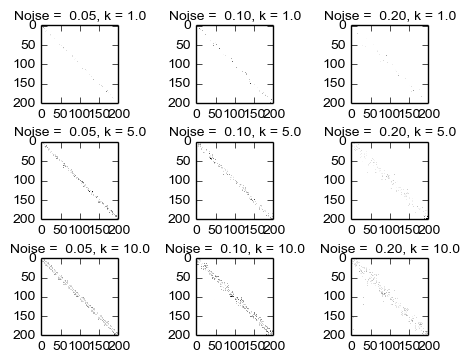

In [74]:
#Generate the adjacency matrices
kNN_graphs = {}
for i in range(len(n_neighbors_list)):
    for j in range(len(noise_level_list)):
        kNN_graphs[n_neighbors_list[i],noise_level_list[j]] = \
        kneighbors_graph(noisy_moons[noise_level_list[j]][0], n_neighbors_list[i], mode='distance', p=2)

#TODO : improve the plots by plotting a scatterplot instead, where edges are added between points iff they are close enough

f, a = plt.subplots(len(n_neighbors_list), len(noise_level_list))
f.subplots_adjust(wspace = 0, hspace=0.5)
for i in range(len(n_neighbors_list)):
    for j in range(len(noise_level_list)):
        a[i,j].imshow(kNN_graphs[n_neighbors_list[i],noise_level_list[j]].todense(),cmap = 'Greys',interpolation="none")
        a[i,j].set_title('Noise =  %.2f, k = %.1f' % (noise_level_list[j], n_neighbors_list[i]),fontsize = 10)

### Question 3 : Optimization problem 

- Given a graph $\mathcal{G} = (E,V)$, let $D$ be its degree matrix and $W$ its weighted ajacency matrix, such that $L := D - W$ is the Laplacian of the graph. In the case when we consider a partition in 2 subsets $A,\bar{A}$, the Normalized Cut problem translates as the following optimization problem:



- $\min_A f^\top L f \text{ s.t. } f_i = 
\begin{cases}
    \sqrt{\frac{\text{Vol}(\bar{A})}{\text{Vol}(A)}},& \text{if } v_i\in A\\
    \sqrt{\frac{\text{Vol}(A)}{\text{Vol}(\bar{A})}},& \text{if } v_i\in \bar{A}
\end{cases}, Df \bot \mathbb{1}, f^\top D f = \text{Vol}(V)$


- This problem is then relaxed as $\min_{f\in \mathbb{R}^n} f^\top L f \text{ s.t. } Df \bot \mathbb{1}, f^\top D f = \text{Vol}(V)$


### Question 4 : Complete the code in the box below



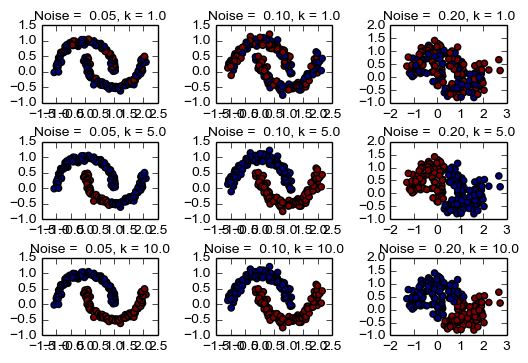

In [76]:
from sklearn.cluster import SpectralClustering

f, a = plt.subplots(len(n_neighbors_list), len(noise_level_list))
f.subplots_adjust(wspace = 0.5, hspace=0.5)
labels = {}
for i in range(len(n_neighbors_list)):
    for j in range(len(noise_level_list)):
        spectral = SpectralClustering(n_clusters=2, \
                            eigen_solver='arpack', affinity="nearest_neighbors", n_neighbors=n_neighbors_list[i])
        labels[n_neighbors_list[i],noise_level_list[j]] = spectral.fit_predict(noisy_moons[noise_level_list[j]][0])
        a[i,j].scatter(noisy_moons[noise_level_list[j]][0][:,0],\
                       noisy_moons[noise_level_list[j]][0][:,1], c = labels[n_neighbors_list[i],noise_level_list[j]])
        a[i,j].set_title('Noise =  %.2f, k = %.1f' % (noise_level_list[j], n_neighbors_list[i]), fontsize = 10)


It seems that increasing the number improves the robustness of the clustering.
However, since it makes the adjacency matrix denser, it also makes the complexity greater.

### Question 5 : Complete the code in the box below

### Question 6 : Complete the code in the box below

### Question 7 : Complete the code in the box below

In [ ]:
from sklearn.cluster import AgglomerativeClustering



### Experiment on MNIST

In [ ]:
# Add your code here

## Semi-Supervised Learning

Choice of the dataset used : **Precise** which dataset you chose and why it is relevant for the semi-supervised learning Task

Advised datasets :

*Breast Cancer Wisconsin (Diagnostic) Database*

*MNIST binary even vs odd (multiple clusters inside each class)*

Feel free to use other datasets if they are relevant

In [ ]:
from sklearn.datasets import load_breast_cancer, load_digits
from sklearn.model_selection import train_test_split


### For all the next questions, use Cancer and Mnist classes to handle your data if you choose to use these one,
### You can also add more datasets but we advise you to handle them with this class for better readability
class semi_sup_dat:
    def __init__(self,data,p_unlabelled,name):
        # DON T CHANGE THE RANDOM STATES
        self.name = name
        if self.name == 'Mnist':
            # do an even vs odd binary classification :
            even = [0,2,4,6,8]
            Y = [int(y in even) for y in data.target]
        else:
            Y = data.target
        X_lab, X_unlab, y_lab, y_unlab = train_test_split(data.data, data.target, test_size=p_unlabelled, random_state=32)
        self.X_lab = X_lab
        self.X_unlab = X_unlab
        self.y_lab = y_lab
        self.y_unlab = y_unlab


# The following lines can be called later in the code to build a dataset with varying unlabelled proportion
p_unlabelled = 0.8 # You can change this value
Cancer = semi_sup_dat(load_breast_cancer(), p_unlabelled,'Cancer')
digits = load_digits()

Mnist = semi_sup_dat(load_digits(), p_unlabelled,'Mnist')

### Question 9 : Complete the code in the box below

In [ ]:
#  Question 9  : Complete the function self_training
from sklearn.neighbors import KNeighborsClassifier





### Question 10 : Complete the code in the box below

###### Closed form expression :

-

-

-

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel # Or reimplement it yourself if your prefer
from scipy.linalg import block_diag

    

### Question 11 : Complete the code in the box below

### Question 12 : Add your answer here

-

-

-

### Question 13 : Complete the code in the box below

### Question 14 : Complete the code in the box below

##### Add your answer to the question here :

-

-

-

### Question 15 : Complete the code in the box below

### Question 16 : Complete the code in the box below

###### Describe your protocol here : 
-

-

-